In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

In [3]:
from drgnet.fundus_datamodules import DDRSegmentationDataModule

dm = DDRSegmentationDataModule("data/DDR-dataset")
dm.setup("validate")
dm.val.transform

Compose([
  Autocrop(always_apply=True, p=1.0, threshold=25.0),
  LongestMaxSize(always_apply=True, p=1, max_size=512, interpolation=1),
  PadIfNeeded(always_apply=True, p=1.0, min_height=512, min_width=512, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=None, mask_value=None),
  Normalize(always_apply=True, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [9]:
img.shape

torch.Size([3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


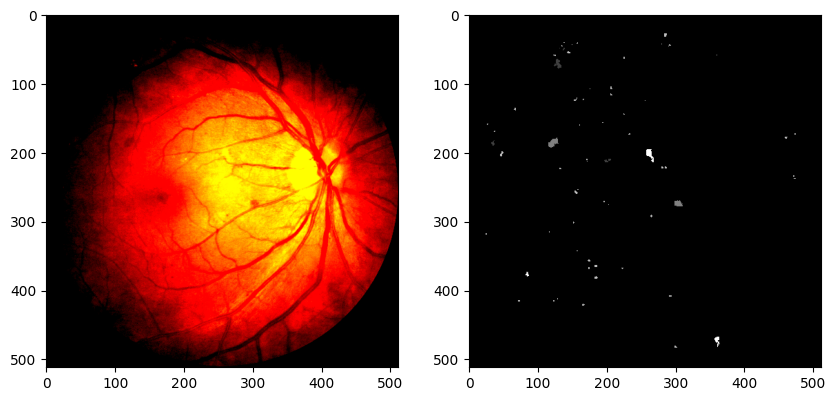

In [19]:
img, mask = dm.val[30]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask, cmap="gray")

In [19]:
print(dm.val.transform.transforms)

NotImplementedError: Class drgnet.fundus_datamodules.utils.autocrop.Autocrop is not serializable because the `get_transform_init_args_names` method is not implemented

# Dataset

In [2]:
from typing import Callable

import pandas as pd
import torch
import torchvision.transforms.v2 as T
from fundus_lesions_toolkit.models import segment
from fundus_lesions_toolkit.utils.images import open_image
from torch.utils.data import DataLoader, Dataset


class Aptos(Dataset):
    def __init__(
        self, root: str | bytes | os.PathLike, transform: Callable[[torch.Tensor], torch.Tensor] | None = None
    ) -> None:
        super().__init__()
        self.root = root
        self.transform = transform
        self.csv = pd.read_csv(os.path.join(root, "train.csv"))
        self.csv["path"] = self.csv["id_code"].apply(lambda x: os.path.join(root, "train", "images", f"{x}.png"))

    def __len__(self) -> int:
        return len(self.csv)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        img = open_image(self.csv["path"][index])
        mask = segment(img).argmax(dim=0) > 0
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        label = torch.tensor(self.csv["diagnosis"][index])
        return img, mask, label

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({len(self)})"


dataset = Aptos(
    "data/aptos/raw/",
    transform=T.Compose([T.ToImage(), T.Resize((1024, 1024)), T.ToDtype(torch.float32, scale=True)]),
)

# Redefine ViT to mask out some patches

In [3]:
import timm
import torch
import torch.nn.functional as F
from timm.models._manipulate import checkpoint_seq
from timm.models.vision_transformer import VisionTransformer as TimmViT

In [4]:
from typing import Literal


class VisionTransformer(TimmViT):
    def forward_features(
        self,
        x: torch.Tensor,
        mask: torch.Tensor | None = None,
        mode: Literal["mask", "index"] = "mask",
        flip_mask: bool = False,
    ) -> torch.Tensor:
        x = self.patch_embed(x)  # (B, C, H, W) -> (B, L, D)
        x = self._pos_embed(x)  # (B, L, D) -> (B, L+1, D)
        x = self.patch_drop(x)  # (B, L+1, D) -> (B, L+1, D)

        if mask is not None:
            patch_size = self.patch_embed.patch_size
            # Downsample mask to patch size. Need to cast `mask` because max_pool2d does not support bool
            mask = F.adaptive_max_pool2d(
                mask.to(x.dtype), (mask.shape[-2] // patch_size[-2], mask.shape[-1] // patch_size[-1])
            ).flatten(
                1
            )  # (B, H, W) -> (B, L)

            if flip_mask:
                mask = 1 - mask

            # keep class token untouched
            mask = torch.cat([mask.new_ones((mask.shape[0], 1)), mask], dim=-1)  # (B, L) -> (B, L+1)

            if mode == "mask":
                x = x * mask.unsqueeze(-1)
            elif mode == "index":
                idx = mask.nonzero(as_tuple=True)  # get the indices of tokens to keep
                x_ = x.new_zeros(x.shape[0], idx[1].max() + 1, x.shape[-1])
                x_[idx] = x[idx]
                x = x_
            else:
                raise ValueError(f"Unknown mode {mode}")

        x = self.norm_pre(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward(
        self,
        x: torch.Tensor,
        mask: torch.Tensor | None = None,
        mode: Literal["mask", "index"] = "mask",
        flip_mask: bool = False,
    ) -> torch.Tensor:
        x = self.forward_features(x, mask, mode, flip_mask)
        x = self.forward_head(x)
        return x


timm.models.vision_transformer.VisionTransformer = VisionTransformer  # Monkey patch timm to use our VisionTransformer

state_dict = torch.load("cosmic-capybara-16.ckpt", map_location="cpu")["state_dict"]
for k in list(state_dict.keys()):
    state_dict[k.replace("model.", "")] = state_dict.pop(k)

model = timm.create_model("vit_base_patch16_384", num_classes=1, img_size=(1024, 1024))
model.load_state_dict(state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
from tqdm import tqdm

# torch.multiprocessing.set_start_method("spawn")
dataloader = DataLoader(dataset, batch_size=1)

data = {
    "preds_no_mask": [],
    "preds_with_mask": [],
    "preds_with_index": [],
    "preds_with_mask_flip": [],
    "preds_with_index_flip": [],
    "labels": [],
}
with torch.inference_mode():
    model.eval()
    for img, mask, label in tqdm(dataloader):
        img = img.to(device)
        mask = mask.to(device)
        label = label.to(device)

        data["preds_no_mask"].extend(model(img).cpu().round().flatten().tolist())
        data["preds_with_mask"].extend(model(img, mask, mode="mask").cpu().round().flatten().tolist())
        data["preds_with_index"].extend(model(img, mask, mode="index").cpu().round().flatten().tolist())
        data["preds_with_mask_flip"].extend(
            model(img, mask, mode="mask", flip_mask=True).cpu().round().flatten().tolist()
        )
        data["preds_with_index_flip"].extend(
            model(img, mask, mode="index", flip_mask=True).cpu().round().flatten().tolist()
        )
        data["labels"].extend(label.cpu().flatten().tolist())

  0%|          | 0/3662 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/fundus_lesions_toolkit/models/segmentation.py:236: UserWarning: Setting dropout to 0.2
  warnings.warn(f"Setting dropout to {initial_value}")
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 3662/3662 [1:42:28<00:00,  1.68s/it]


In [10]:
import pickle

with open("dump.pkl", "wb") as f:
    pickle.dump(data, f)

In [11]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

for pred in ("preds_no_mask", "preds_with_mask", "preds_with_index", "preds_with_mask_flip", "preds_with_index_flip"):
    acc = accuracy_score(data["labels"], data[pred])
    prec = precision_score(data["labels"], data[pred], average="macro", zero_division=0)
    rec = recall_score(data["labels"], data[pred], average="macro")
    f1 = f1_score(data["labels"], data[pred], average="macro")
    kappa = cohen_kappa_score(data["labels"], data[pred], weights="quadratic")

    print(pred.removeprefix("preds_").replace("_", " ").capitalize())
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 (macro): {f1:.4f}")
    print(f"Cohen Kappa: {kappa:.4f}")
    print()

No mask
Accuracy: 0.7449
Precision (macro): 0.5760
Recall (macro): 0.5363
F1 (macro): 0.5354
Cohen Kappa: 0.8709

With mask
Accuracy: 0.1879
Precision (macro): 0.3115
Recall (macro): 0.2928
F1 (macro): 0.1911
Cohen Kappa: 0.5281

With index
Accuracy: 0.1849
Precision (macro): 0.3026
Recall (macro): 0.2890
F1 (macro): 0.1879
Cohen Kappa: 0.5201

With mask flip
Accuracy: 0.5238
Precision (macro): 0.4293
Recall (macro): 0.2765
F1 (macro): 0.2694
Cohen Kappa: 0.3516

With index flip
Accuracy: 0.5238
Precision (macro): 0.4293
Recall (macro): 0.2765
F1 (macro): 0.2694
Cohen Kappa: 0.3516



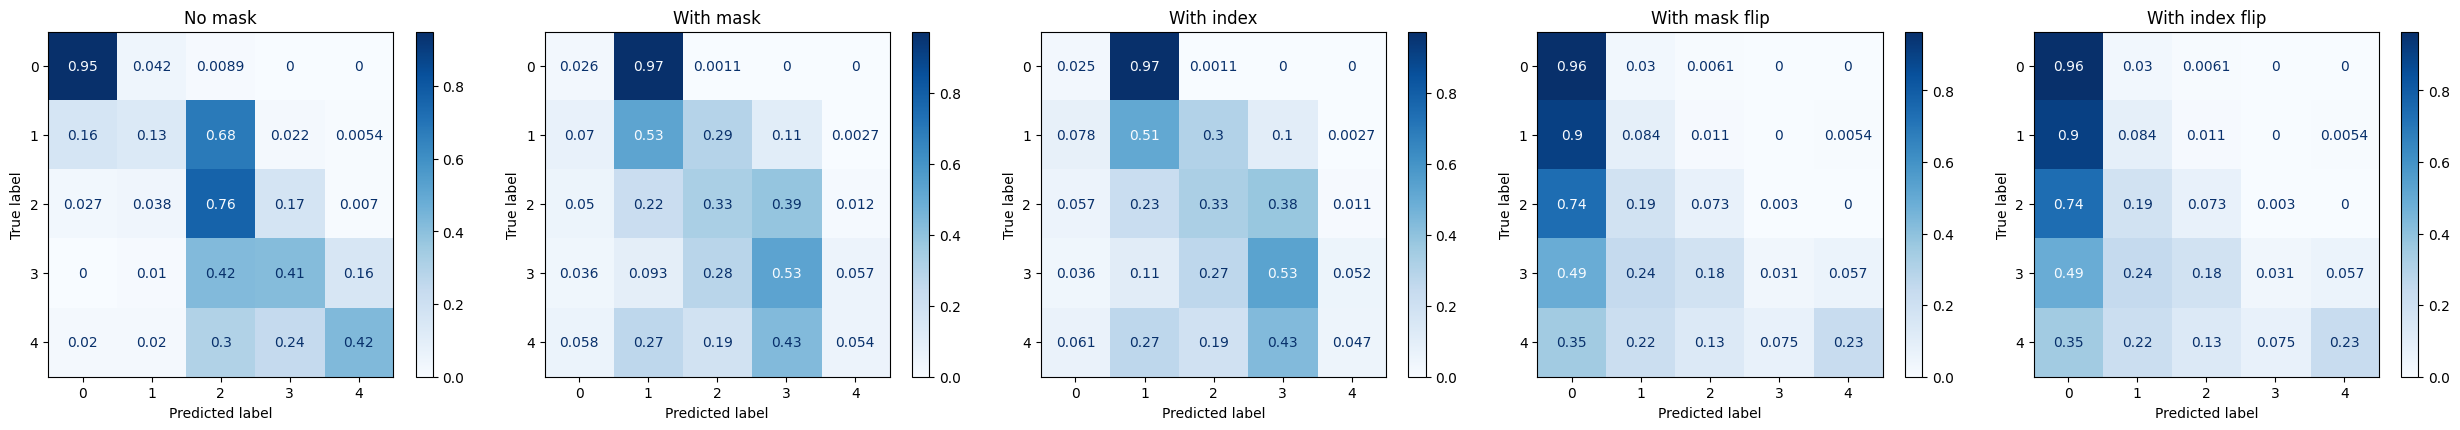

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, axs = plt.subplots(1, 5, figsize=(25, 4))

for pred, ax in zip(
    ("preds_no_mask", "preds_with_mask", "preds_with_index", "preds_with_mask_flip", "preds_with_index_flip"), axs
):
    # cm = confusion_matrix(data["labels"], data[pred], normalize="true")
    ConfusionMatrixDisplay(confusion_matrix(data["labels"], data[pred], normalize="true")).plot(ax=ax, cmap="Blues")
    # ax.imshow(cm, cmap="Blues")
    ax.set_title(pred.removeprefix("preds_").replace("_", " ").capitalize())
    # ax.set_xlabel("Predicted")
    # ax.set_ylabel("True")

fig.tight_layout()
fig.savefig("confusion_matrices.png")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'Mask (rounded bilinear)')

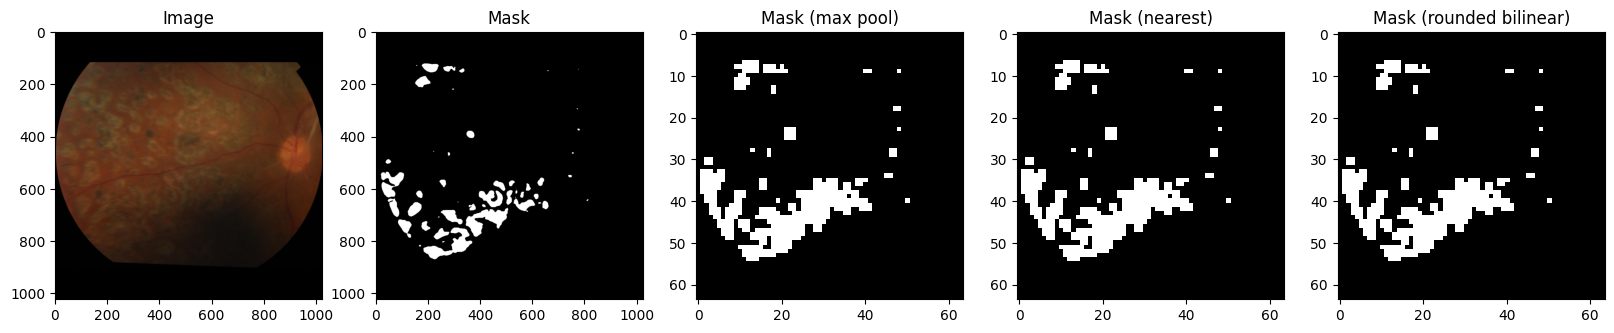

In [8]:
import matplotlib.pyplot as plt

for img, mask, labels in DataLoader(dataset, batch_size=2, shuffle=True):
    if labels[0] == 4:
        img = img.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        break

mask_max = F.adaptive_max_pool2d(mask, (mask.shape[-2] // 16, mask.shape[-1] // 16))
mask_nearest = F.interpolate(mask_max, (mask.shape[-2] // 16, mask.shape[-1] // 16), mode="nearest")
mask_bilinear = F.interpolate(mask_max, (mask.shape[-2] // 16, mask.shape[-1] // 16), mode="bilinear").round()

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(img[0].permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Image")
ax[1].imshow(mask[0].squeeze().cpu().numpy(), cmap="gray")
ax[1].set_title("Mask")
ax[2].imshow(mask_max[0].squeeze().cpu().numpy(), cmap="gray")
ax[2].set_title("Mask (max pool)")
ax[3].imshow(mask_nearest[0].squeeze().cpu().numpy(), cmap="gray")
ax[3].set_title("Mask (nearest)")
ax[4].imshow(mask_bilinear[0].squeeze().cpu().numpy(), cmap="gray")
ax[4].set_title("Mask (rounded bilinear)")

# torch.testing.assert_close(mask_nearest, mask_bilinear, rtol=0, atol=0)
# torch.testing.assert_close(mask_nearest, mask_max, rtol=0, atol=0)
# torch.testing.assert_close(mask_bilinear, mask_max, rtol=0, atol=0)

# %timeit mask_max = F.adaptive_max_pool2d(mask, (mask.shape[-2] // 16, mask.shape[-1] // 16))
# %timeit mask_nearest = F.interpolate(mask_max, (mask.shape[-2] // 16, mask.shape[-1] // 16), mode="nearest")
# %timeit mask_bilinear = F.interpolate(mask_max, (mask.shape[-2] // 16, mask.shape[-1] // 16), mode="bilinear").round()

In [9]:
with torch.inference_mode():
    model.eval()
    print(model(img, mask, mode="index").squeeze(), model(img, mask, mode="mask").squeeze())

tensor([0.2880, 0.6123], device='cuda:0') tensor([0.2944, 0.6221], device='cuda:0')
